In [134]:

import warnings 
warnings.filterwarnings('ignore')

import tensorflow as tf 
from tensorflow import keras 

import cv2 

import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 


In [ ]:
'''
PROJECT - TRAJECTORY PREDICTION OF AUTOMOBILES / PREDESTRIANS FOR SELF DRVING CARS 

PIPELINE - 
1. Took dataset of windshield view with Bounding Boxes , did preprocessing and used Transfer LEarning to 
re-train the model a bit to learn the features in new dataset and predicted Centre( exact location) of the predestrain
/vehicle 

2. Then , tokk the last feature map fromCNN ( contain imp features ) and passed it to the RNN ( after reshaping input)
such that ( timesteps = Spatial Dim , features= no of new channels formed  in Final feature map )

3. trained my LSTM network for One-strp forecasting( New pos of Pedestrian )

Do this work now 

4. Now , wok on  tuning both the models m fianl results , do mUlti-Step Forecasting to predict future 10 steps 

5. And draw lines represing them and integrate it toa  video frame . 

'''

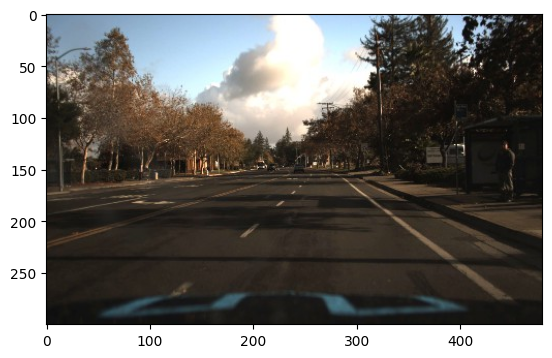

In [135]:
img = cv2.imread("/kaggle/input/self-driving-cars/images/1478019952686311006.jpg")
img = cv2.cvtColor( img , cv2.COLOR_BGR2RGB)
plt.imshow( img  , cmap = 'gray')

In [136]:
data = pd.read_csv("/kaggle/input/self-driving-cars/labels_train.csv")


In [137]:
data.head(3)

,frame,xmin,xmax,ymin,ymax,class_id
0,1478019952686311006.jpg,237,251,143,155,1
1,1478019952686311006.jpg,437,454,120,186,3
2,1478019953180167674.jpg,218,231,146,158,1


In [138]:
''' Define the center of B  Box to find exact location '''
pos = data.copy()

pos['x_pos'] = (pos['xmin'] + pos['xmax'])//2 
pos['y_pos'] = (pos['ymin'] + pos['ymax'])//2 

pos.drop(['xmin' , 'xmax' , 'ymin' , 'ymax' , 'class_id'] , axis =1  , inplace = True )

In [139]:
pos.head()

,frame,x_pos,y_pos
0,1478019952686311006.jpg,244,149
1,1478019952686311006.jpg,445,153
2,1478019953180167674.jpg,224,152
3,1478019953689774621.jpg,176,147
4,1478019953689774621.jpg,185,149


In [140]:
pos_1 = pos.iloc[: , 1: ]

from sklearn.preprocessing import StandardScaler 
scale = StandardScaler( )
pos[ ['x_pos' , 'y_pos']]  = scale.fit_transform( pos[['x_pos' , 'y_pos' ]] )

# pos.drop( ['x_pos' , 'y_pos'] , axis =1 , inplace =True  )

# pos = pd.concat( [ pos , pos_1 ] , axis =1 )




In [141]:
pos.head()

,frame,x_pos,y_pos
0,1478019952686311006.jpg,0.223195,0.066956
1,1478019952686311006.jpg,1.982468,0.262320
2,1478019953180167674.jpg,0.048143,0.213479
3,1478019953689774621.jpg,-0.371982,-0.030726
4,1478019953689774621.jpg,-0.293209,0.066956


In [142]:
''' Take the features of the image , and pass it to LSTM network and use the 
sequential Box Coord as the label '''

from keras.applications  import Xception

base_model =  Xception( include_top = False ,weights= 'imagenet', input_shape = (299 , 299 , 3 )) 


for layer in base_model.layers :
    layer.trainable = False 
    
Cnn = keras.models.Sequential([
   base_model,
    #keras.layers.GlobalAveragePooling2D() ,
    keras.layers.Flatten() ,
    keras.layers.Dense( 512 ,activation = 'relu') , 
    keras.layers.Dropout(0.2), 
    keras.layers.Dense(256 , activation = 'relu'), 
    keras.layers.Dropout(0.2 ) ,
    keras.layers.Dense(2 )
])

Cnn.compile( loss = 'mse' , optimizer = 'adam' , metrics=['mae'])

In [143]:
Cnn.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [144]:
'''  Travel in the Dir of images and store first 10 images for training
and their labels PArallely '''

root = "/kaggle/input/self-driving-cars/images/"

Img_data = []
Labels = []

for i in range( 10 ):
    img = cv2.imread(root +pos['frame'].iloc[i])
    img= img/255
    img = cv2.resize( img , (299,299 ))
    Img_data.append(img)
    Labels.append([pos['x_pos'].iloc[i] , pos['y_pos'].iloc[i]] )
    

In [145]:
Img_data = np.array(Img_data)
Labels = np.array( Labels )

In [146]:
Cnn.fit( Img_data , Labels , epochs = 5 )

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - loss: 1.5432 - mae: 0.9022
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 4416.6890 - mae: 53.2357
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 439.8419 - mae: 18.5541
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 618.3981 - mae: 20.0111
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 399.8151 - mae: 17.5910


In [147]:
base_model_ = Cnn.layers[0]

In [148]:
feature_map = base_model.predict(Img_data[:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [149]:
batch , h , w , ch = feature_map.shape


In [165]:
''' to reshape Out of any model to any other mode , ise layers.Reshape( ( h*w , channesl)) '''

Lstm_net = keras.models.Sequential([
    base_model_ , 
    keras.layers.Reshape( ( h*w , ch )) , 
#     keras.layers.Input( shape = ( h*w*ch , )) ,
    keras.layers.LSTM( units = 100  , 
                      activation = "relu" , input_shape = (h*w , ch ), return_sequences =True), 
    keras.layers.LSTM( units = 50  , activation = "relu"   ) , 
    keras.layers.Dense(  2  ) 
])
Lstm_net.compile( loss= 'mse' , optimizer = 'adam' , metrics=['mae'])

In [161]:
Lstm_net.summary()


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_38 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [166]:
Lstm_net.fit( Img_data , Labels , epochs =5 )


Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.5368 - mae: 0.4903
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.5397 - mae: 0.5791
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 19833.2188 - mae: 89.1386
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 2.2620 - mae: 1.0237
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 6.6516 - mae: 2.0352


In [177]:

coord = Lstm_net.predict( Img_data[:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


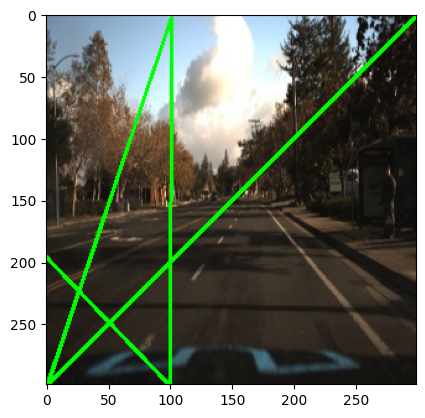

In [208]:
'''

Notes - Did Feature Scaling For correct and FFaster Convergence to Solution .
'''
x = coord[0][0]
y = coord[0][1]

t = ( int(x ) , int(y))

green = ( 0 , 255 , 0 )
cv2.line(Img_data[1:2][0], t, (100, 300), green , 2 )

''' To revrse the 3 COlor Channels'''
plt.imshow(Img_data[:1][0][:,:,::-1] , cmap = plt.cm.Spectral )

tuple

In [ ]:
angle_spectru_m